# Mortality Rate Estimation 

The data found for previous disease outbreaks will come into use to tune the model for regression. We will mostly focus on other Coronaviruses outbreaks (i.e., SARS or MERS) to construct the estimates.

In [11]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[40,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

## SARS

The dataset on the 2003 SARS outbreak was found on Kaggle and based on WHO reports during the crisis.

In [3]:
# sars_ts = pd.read_excel('data/time_series/SARS.xlsx', usecols=list(range(4)), parse_dates=[1]).set_index('Date', drop=True).rename({"Mortality": "Dead"}, axis=1)
sars_ts = pd.read_csv('data/time_series/SARS.csv', header=0)

## Survivability Rate

First, we must calculate the survival rate $S_{SARS}$ from our data. A value of $90.36\%$ is in line with the rate in [this paper](doi:10.1016/j.socscimed.2006.08.004) (as per Wikipedia, as I have no access to the paper). 

In [88]:
def calculate_survival_rate(ts, dead_col='Dead', infected_col='Infected'):
    return 1 - ts.iloc[-1][dead_col] / ts.iloc[-1][infected_col]

In [156]:
S_sars = calculate_survival_rate(sars_ts)
S_sars

0.9036387341472087

## Estimate Mortality Curve

Given that the mortality data available is only aggregate level, we must consider the sum of deltas to have a smoother objective function to estimate.

In [125]:
smooth_sars_ts = sars_ts.diff().resample('W').sum()

Once we have our smoothed time series, we need to develop a model to estimate the mortality curve, and by consequence, estimate the hazard function of epidemic outbreaks.

Let $t \in \{1, \dots, T\}$ be the discrete amount of time ellapsed since the beginning of an infection outbreak, where $T$ is the collection period of outbreak data. Furthermore, for any patient, let $k \in \{0, \dots, K\}$ represent the amount of time ellapsed since they have been infected (independent of $t$). In this case, $K$ is the time to outcome where the outcome can represent recovery or death.

Given these two units of time, we can develop a simplistic framework to model the evolution of mortality during an infection. We define $X_t$ and $d_t$ as the number of new infections and deaths, respectively, at a time period $t$. 

We further the probability of a person passing away exactly at time period w (after initial infection) as $h_k$ and the number of people who were infected at time $t$ and are alive after $k$ time periods of infection (i.e., person is alive $t + k$ periods after initial outbreak) is $a_{t, k}$.

First, note that we can simply define the number of mortality at time $t$ as 

$$ d_t = \sum^{t}_{i=1} h_{t-i} a_{i, t-i} $$

Then, $a_{t, k}$ can also be defined recursively as:

\begin{align*}
    \begin{aligned}
        a_{t, 0} &= X_t \\ 
        a_{t, k+1} &= (1-h_k)a_{t, k} \quad \forall t \leq T, k \leq K 
    \end{aligned} 
    \implies 
    a_{t, k} = \prod_{j=1}^k(1-h_j)X_t \quad \forall t \leq T, k \leq K 
\end{align*}

Now, let us assume that our hazard rate (the probability of dying after $k$ periods) is a constant $\alpha$ such that $h_0, ..., h_k = \alpha$. This implies that,

$$ a_{t, k} = (1-\alpha)^kX_t $$

, and that,

$$ d_t = \sum^{\min(t, K)}_{i=0} \alpha (1 - \alpha)^k X_{t-k} $$

Therefore, we can derive an estimator $\hat{d_t}$ for $d_t$ by solving the following optimization problem:

\begin{align*}
    \underset{\alpha, K}{\min} \quad& \left|\left| d - \hat{d} \right|\right| \\
    s.t. \quad & \hat{d_t} = \sum^{\min(t, K)}_{i=0} \alpha (1 - \alpha)^k X_{t-k} \\
         & 0 \leq \alpha \leq 1
\end{align*}


In [78]:
def calculate_d_hat(X, alpha, T, K):
    d_hat = np.zeros(T)

    for t in range(T):
        for k in range(min(t+1, K)):
            d_hat[t] += alpha * ((1 - alpha) ** k) * X[t - k]

    return d_hat

def estimate_death_curve(X, d, S=None, K=None, verbose=True):
    T = X.size
    
    minimum_alpha = None
    minimum_K = None
    minimum_distance = None
    minimum_d_hat = None
    
    change_K_flag = (K is None and S is not None)
    
    alpha_space = np.linspace(0.0001, 0.1, 1000)
    
    for alpha in alpha_space:
        if change_K_flag:
            K = int(np.ceil(np.log(S) / np.log(1 - alpha)))
        
        d_hat = calculate_d_hat(X, alpha, T, K)
        
        distance = np.linalg.norm(d - d_hat)

        if minimum_distance is None or distance < minimum_distance:
            minimum_distance = distance
            
            minimum_d_hat = d_hat
            minimum_K = K
            minimum_alpha = alpha
            
    if verbose:
        print(f"Minimum distance={minimum_distance}\nOptimal K={minimum_K}\nOptimal alpha={minimum_alpha}")
            
    return pd.DataFrame.from_dict({"d": d, "d_hat": minimum_d_hat})

In [212]:
death_curve = estimate_death_curve(
    smooth_sars_ts['Infected'].values,
    smooth_sars_ts['Dead'].values,
    S_sars
)

Minimum distance=70.07329488553485
Minimum K=5


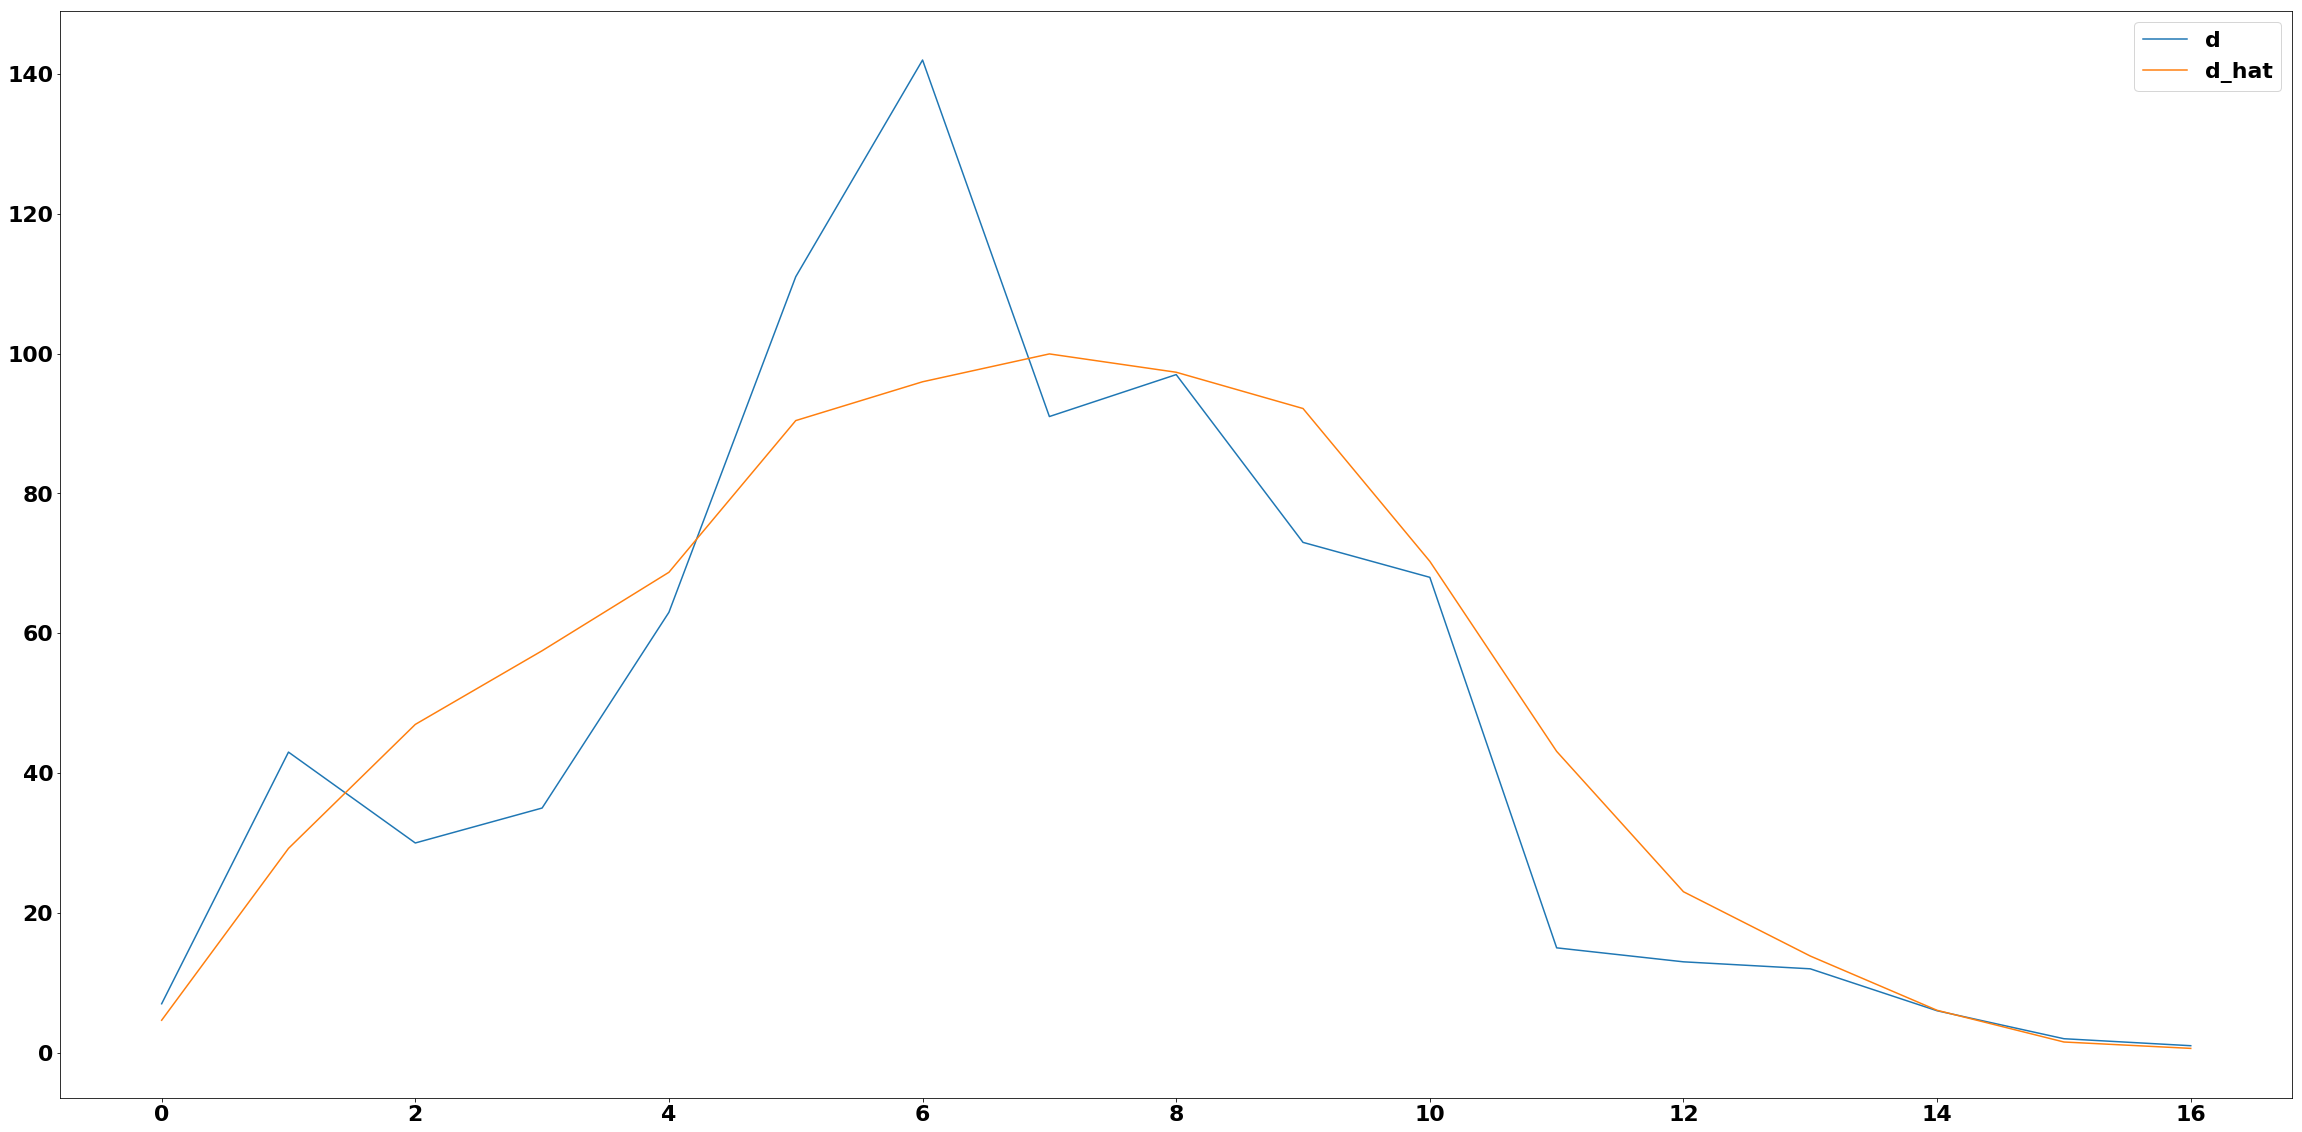

In [213]:
death_curve.plot()

## Censored Data

In [85]:
def mortality_interval(mortality_rate, interval_size=0.2):
    lower_valid_range = mortality_rate - (mortality_rate * interval_size)
    upper_valid_range = mortality_rate + (mortality_rate * interval_size)
    
    return lower_valid_range, upper_valid_range

In [86]:
censor = lambda x, n: x.iloc[:n]

In [82]:
def plot_censored_mortality_rate_estimation_evolution(ts, censor_start, censor_end, survival_rate=None, K=None):
    results = []
    
    for i in range(censor_start, censor_end):
        censored_ts = censor(ts, i)

        censored_ts['Estimate Dead'] = estimate_death_curve(
            censored_ts['Infected'].values,
            censored_ts['Dead'].values,
            S=survival_rate,
            K=K,
            verbose=False
        ).set_index(censored_ts.index)['d_hat']

        estimated_mortality_rate = 1 - calculate_survival_rate(censored_ts.cumsum(), dead_col='Estimate Dead')

        results.append(estimated_mortality_rate)


    fig, ax = plt.subplots()
    plt.plot(range(censor_start, censor_end), results)
    
    if survival_rate is not None:
        lower_mortality, upper_mortality = mortality_interval(1 - survival_rate)
        plt.hlines([lower_mortality, upper_mortality], censor_start, censor_end, colors='red')

        lower_mortality, upper_mortality = mortality_interval(1 - survival_rate, 0.1)
        plt.hlines([lower_mortality, upper_mortality], censor_start, censor_end, colors='orange')

        lower_mortality, upper_mortality = mortality_interval(1 - survival_rate, 0.05)
        plt.hlines([lower_mortality, upper_mortality], censor_start, censor_end, colors='green')
    
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


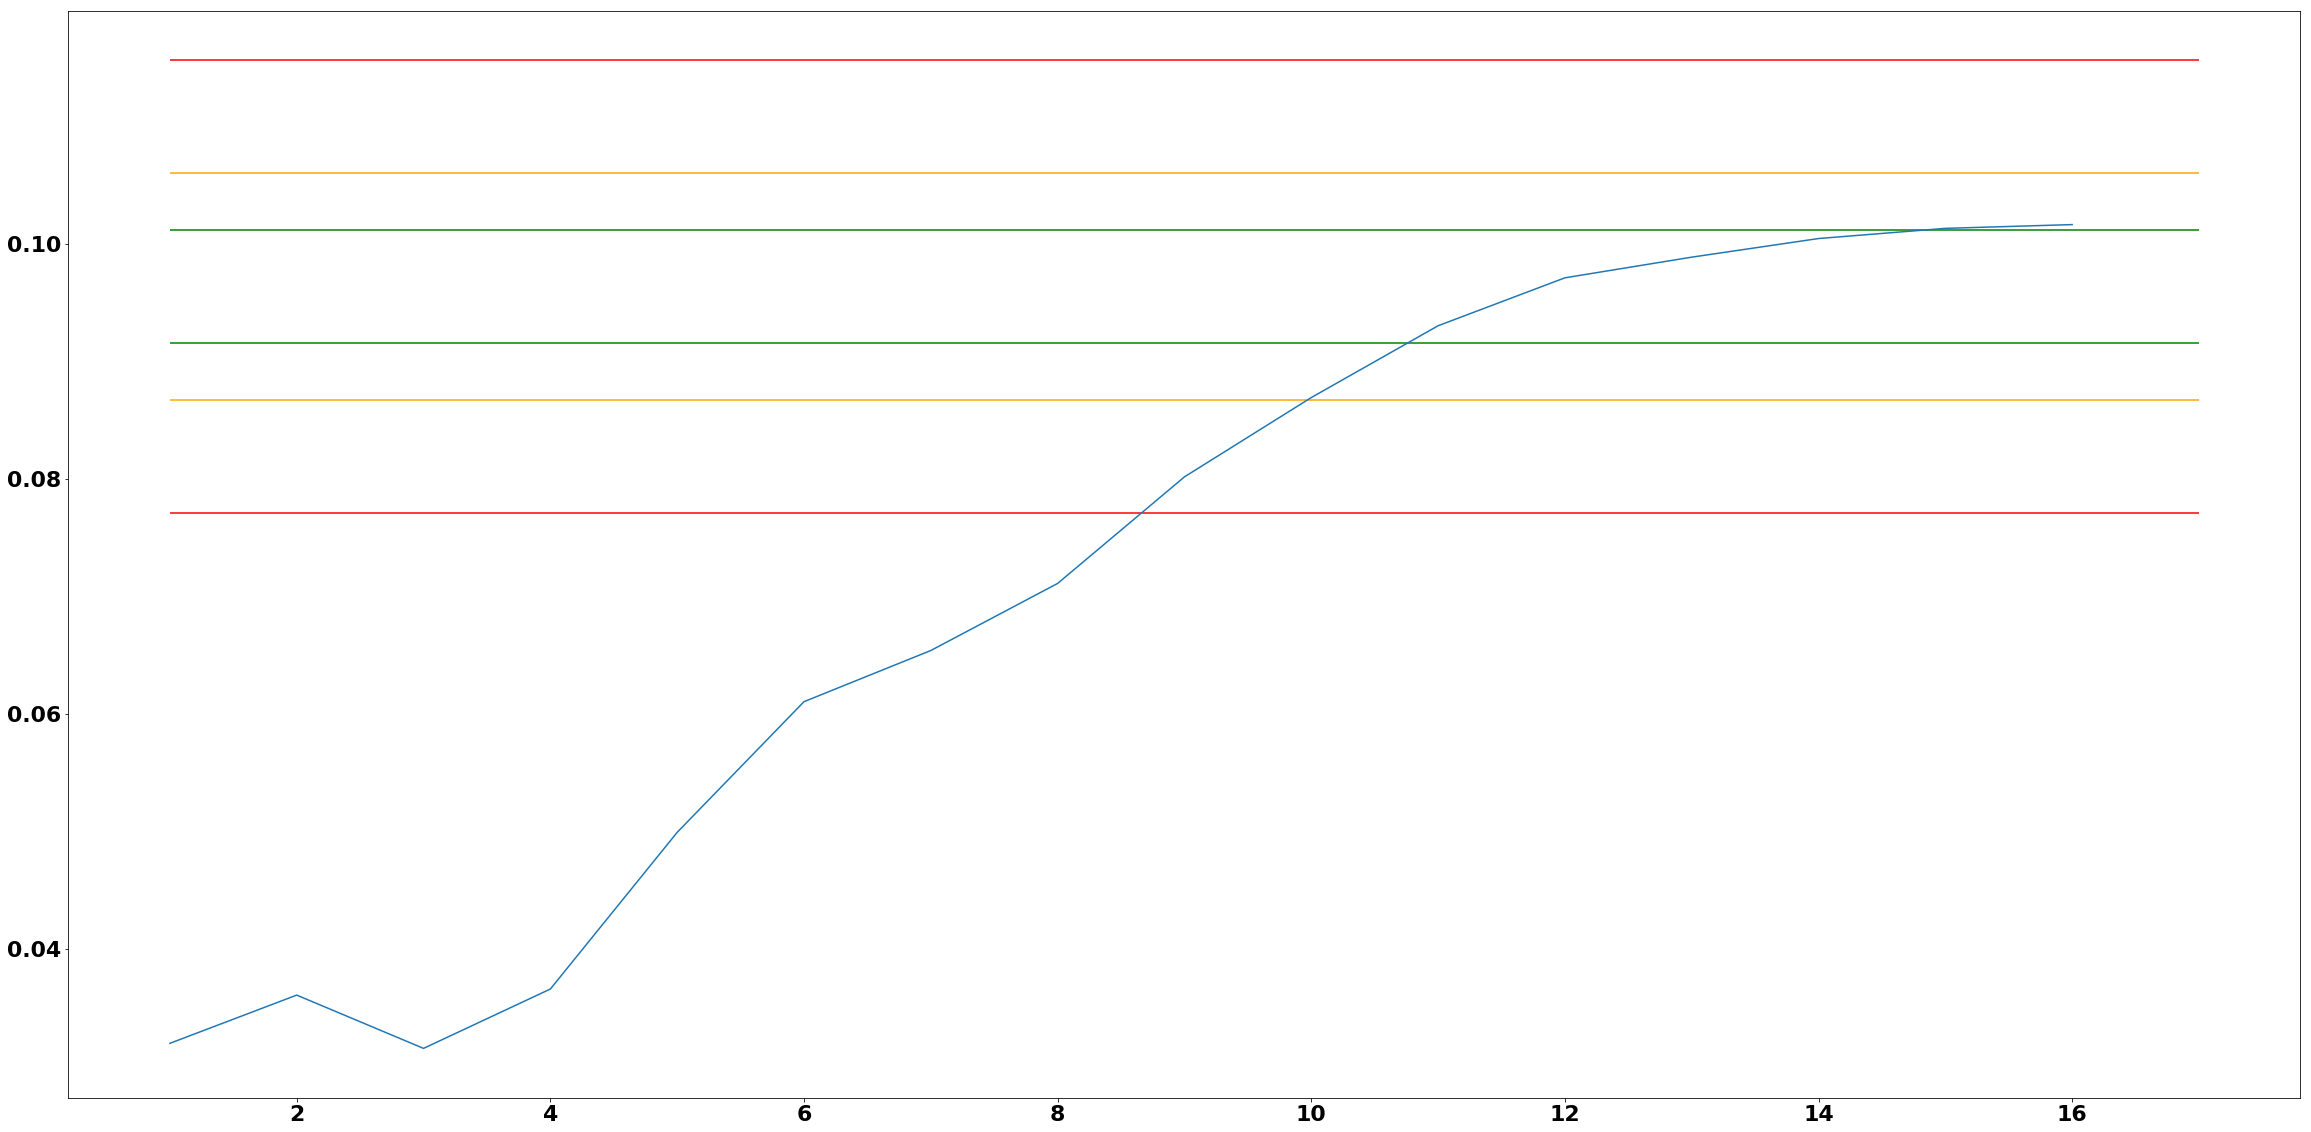

In [220]:
plot_censored_mortality_rate_estimation_evolution(smooth_sars_ts, 1, smooth_sars_ts.shape[0], S_sars)

## MERS

In [157]:
mers_ts = pd.read_csv('data/time_series/MERS_me.csv', parse_dates=[0], index_col=0)

In [158]:
smooth_mers_ts = mers_ts.diff().resample('W').sum()

In [159]:
S_mers = calculate_survival_rate(mers_ts)
S_mers

0.7354709418837675

Minimum distance=14.091014856394814
Minimum d_hat=[0.         1.1688     1.73675888 2.44419857 2.32067259 2.37248681
 2.37341082 2.59482308 2.45091329 2.15199857 2.54393287 2.57400154
 6.17916328 6.54838648 5.53239962 2.32918678 1.66966718 2.72739809
 3.27244075 2.55546575 1.69345885 0.96125492 1.65254168 1.69209711
 1.79942159 1.12851865 1.53709217 2.00327063 1.88548681 1.05724462
 0.23805147 0.0974     0.08791324 0.07935049 0.         0.
 0.0974     0.08791324 0.07935049 0.         0.         0.
 0.         0.         0.         0.1948     0.56542648 0.89995394
 1.05865492 1.15605492 0.85436816 0.77686569 0.53789021 0.80347795
 1.19215394 3.65999464 7.78962415 8.57496249 6.80575207 3.60740594
 3.11558779 2.51129026 1.55047307 0.39675245 0.3896     0.83865296
 1.14656816 1.04060541 0.87334168 0.69659119 0.51127795 0.44141422
 0.64477697 1.09475394 1.4292814  1.78278238 1.47160886]
Minimum K=3


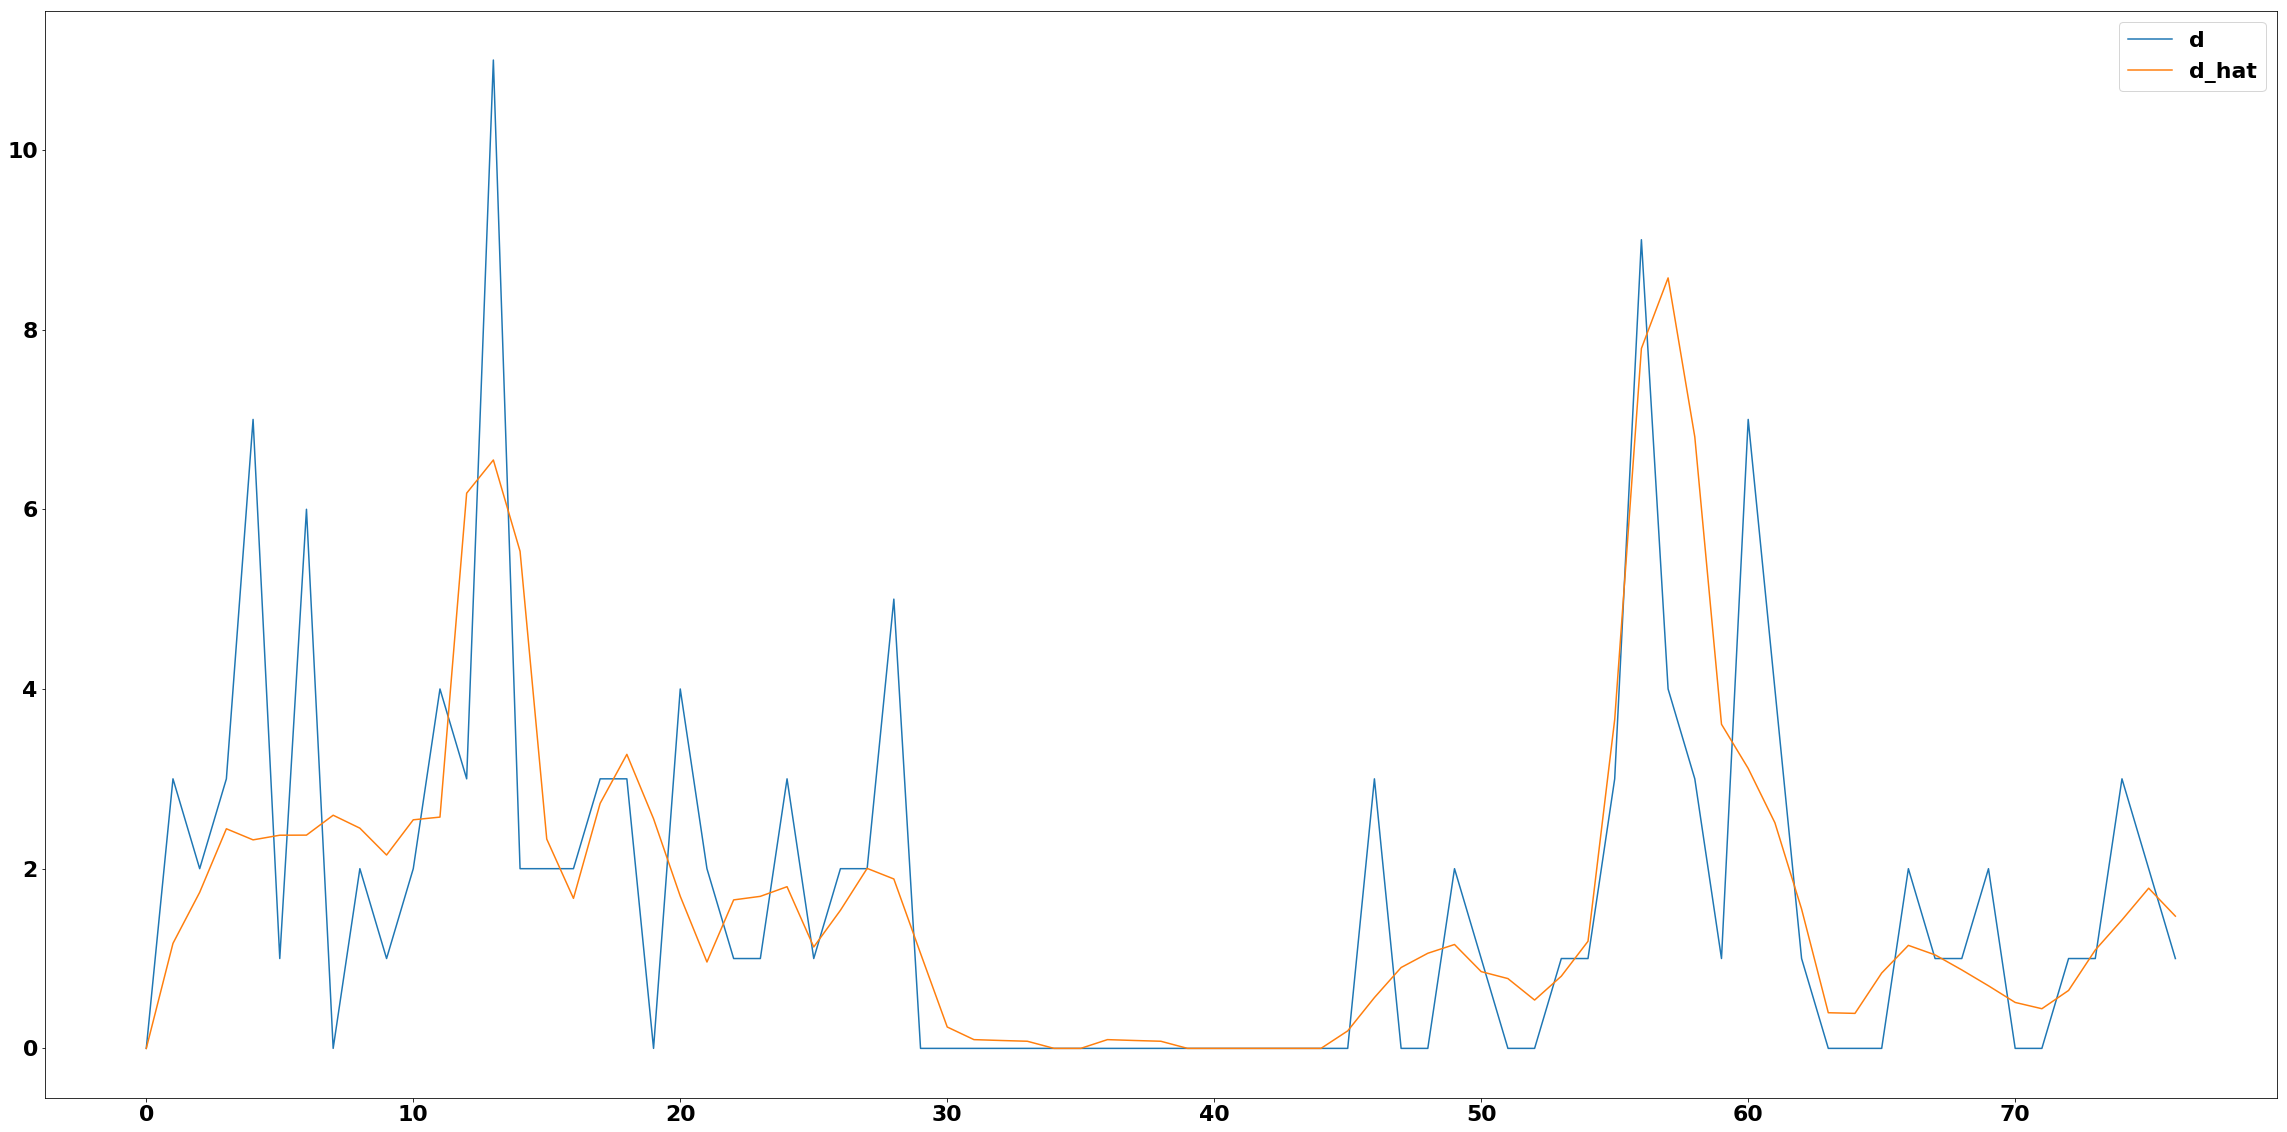

In [71]:
estimate_death_curve(
    smooth_mers_ts['Infected'].values,
    smooth_mers_ts['Dead'].values,
    S_mers
).plot()

Clearly, there are two sepeare outbreaks in this dataset. One ending before week 60 (seems like week 57) and the other starting at week 90.

In [78]:
first_mers_ts = smooth_mers_ts.loc[:"2018-01-28"]
second_mers_ts = smooth_mers_ts.loc["2018-09-09":]

In [55]:
first_death_curve = estimate_death_curve(
    first_mers_ts['Infected'].values,
    first_mers_ts['Dead'].values,
    S_mers
)

first_death_curve.plot()

Minimum distance=10.879841451050654
Minimum K=3


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


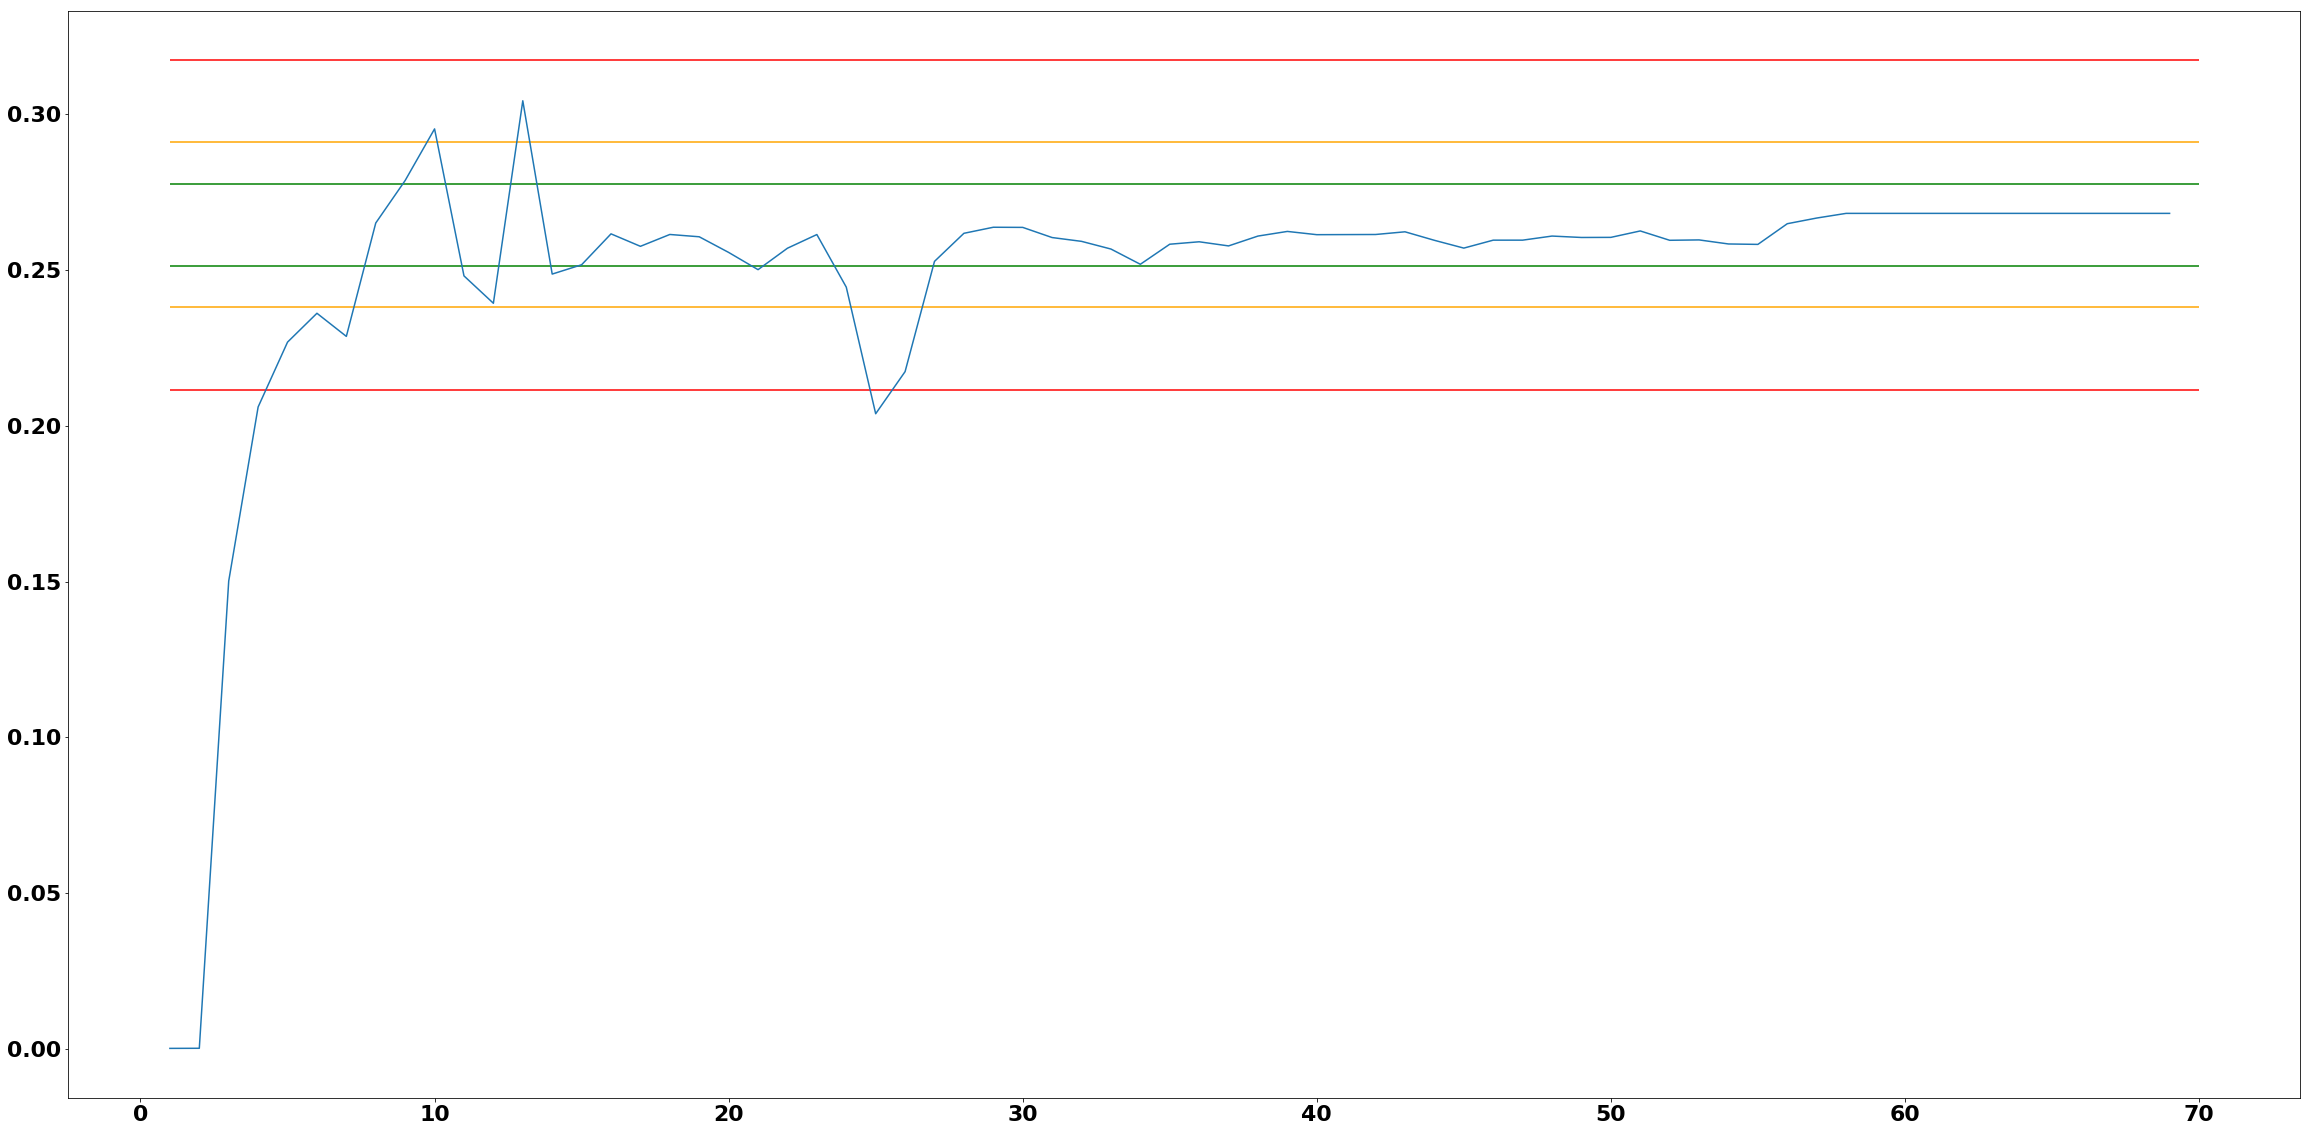

In [170]:
plot_censored_mortality_rate_estimation_evolution(first_mers_ts, 1, 70, S_mers)

Minimum distance=8.837667050760091
Minimum K=3


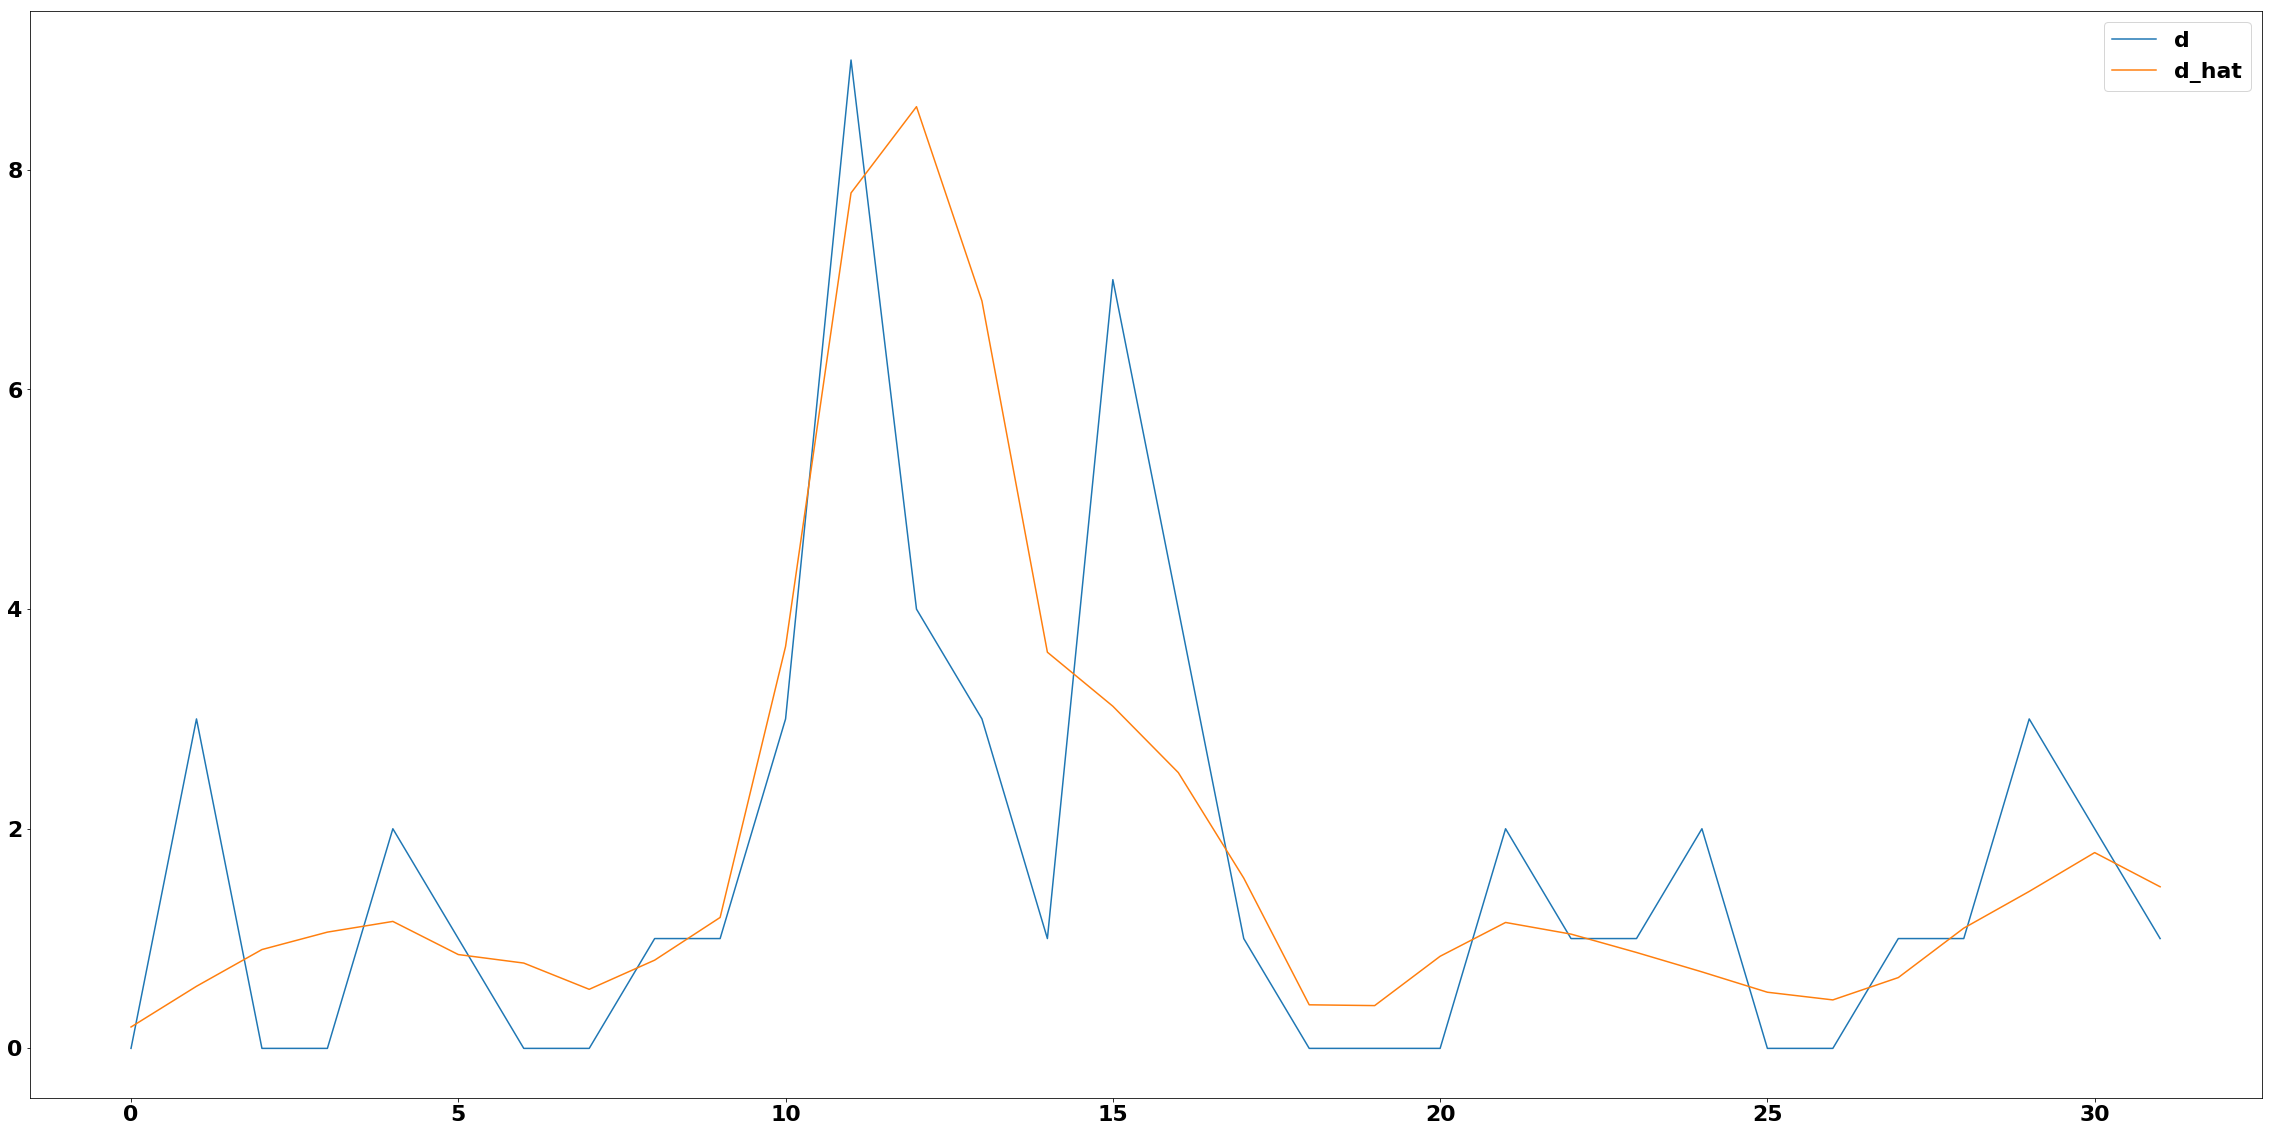

In [57]:
second_death_curve = estimate_death_curve(
    second_mers_ts['Infected'].values,
    second_mers_ts['Dead'].values,
    S_mers
)

second_death_curve.plot()

## Ebola

In [171]:
ebola_guinea_ts = pd.read_csv('data/time_series/ebola_guinea.csv', parse_dates=[0], index_col=0)

In [172]:
S_ebola = calculate_survival_rate(ebola_guinea_ts)
S_ebola

0.37839450910176065

In [173]:
smooth_ebola_ts = ebola_guinea_ts.diff().resample('W').sum()

Minimum distance=160.4022731585056
Minimum K=10


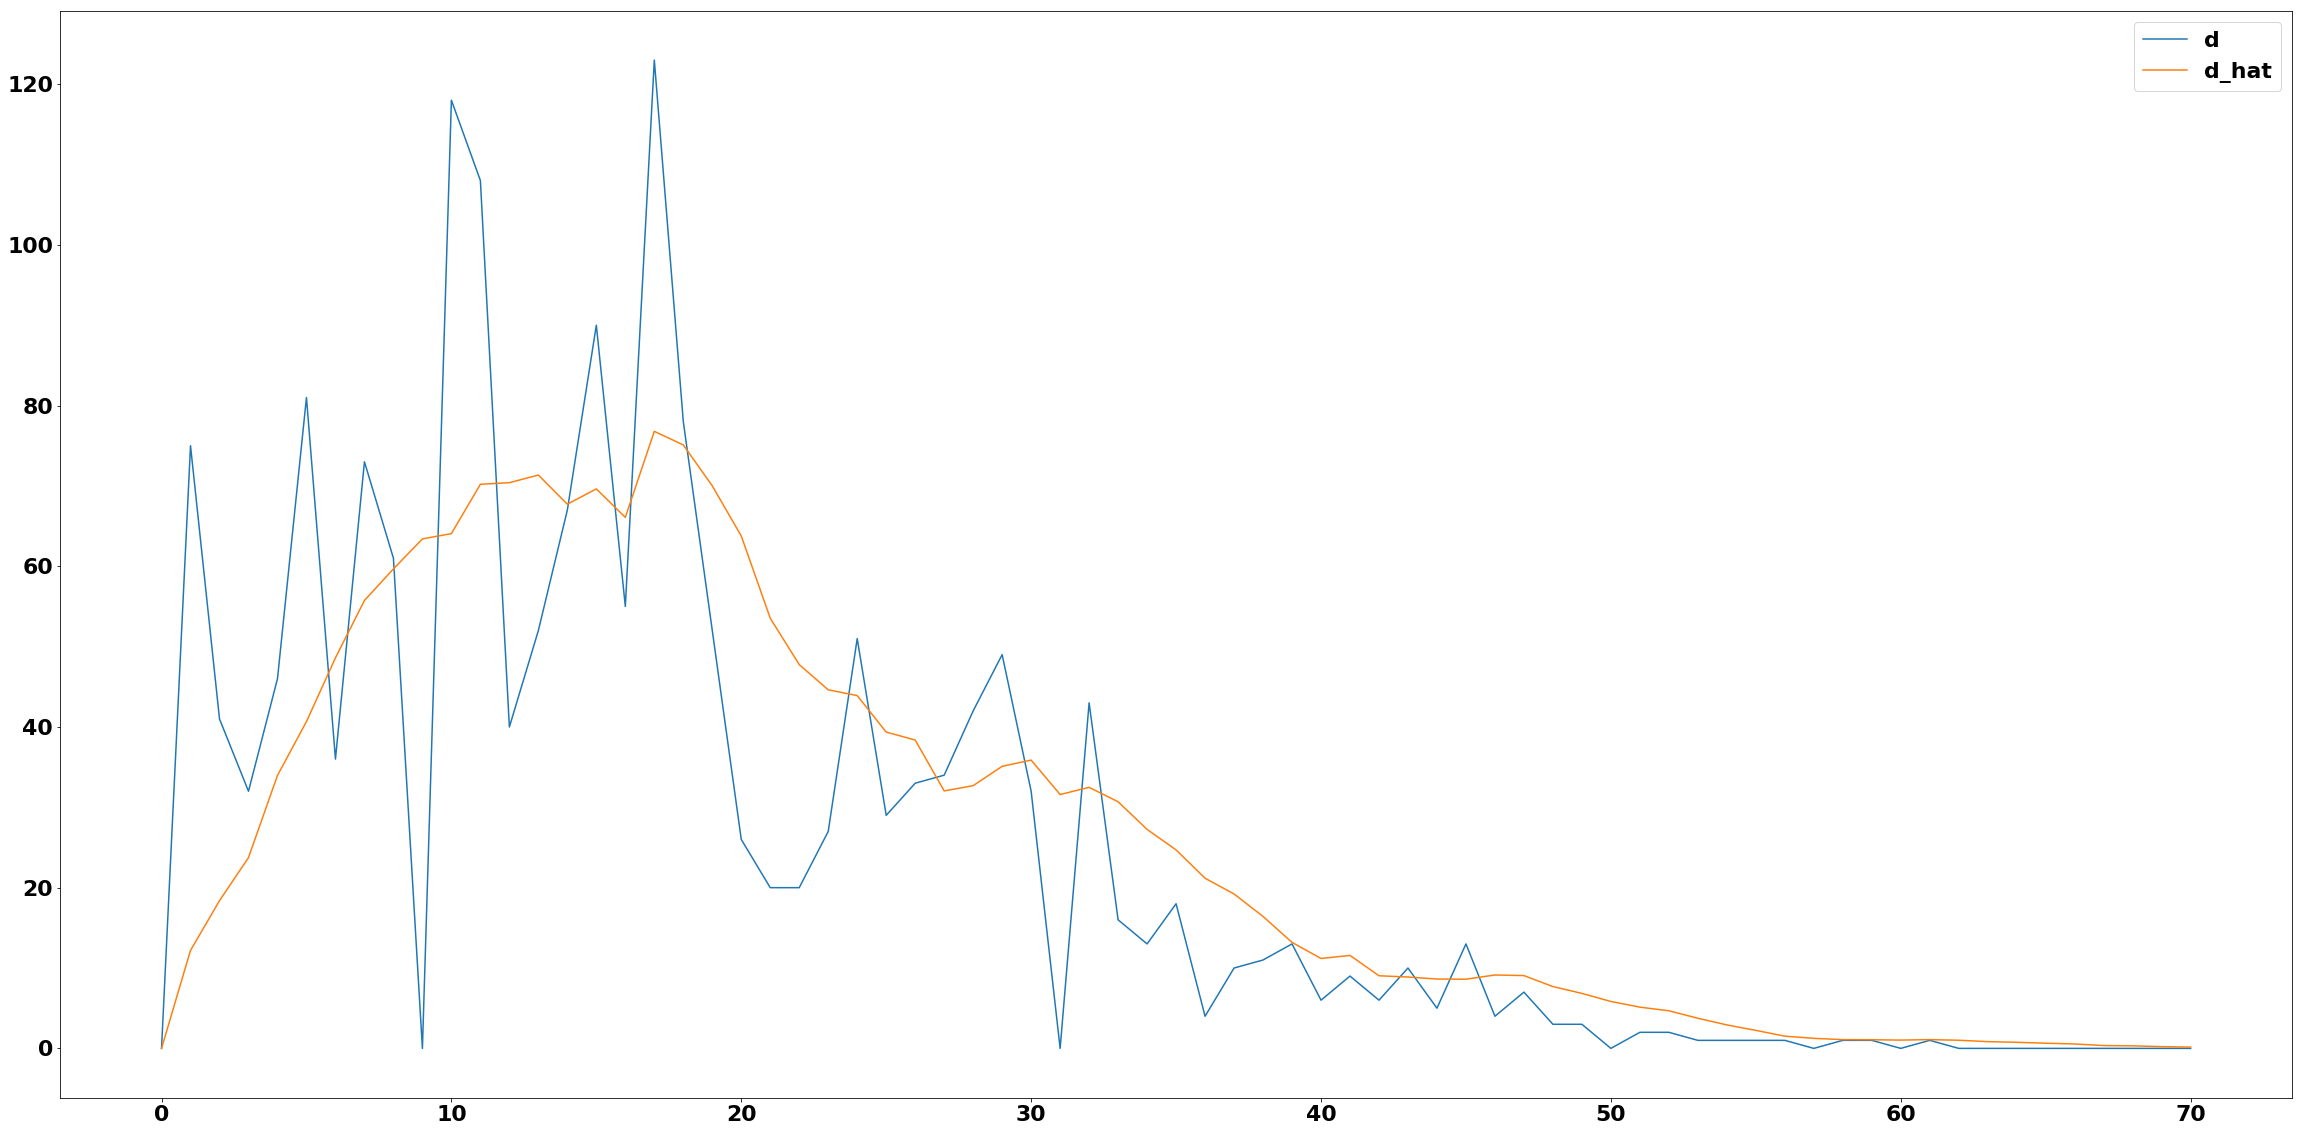

In [188]:
estimate_death_curve(
    smooth_ebola_ts['Infected'].values,
    smooth_ebola_ts['Dead'].values,
    S_ebola
).plot()

## Coronavirus

In [68]:
coronavirus_df = pd.read_csv('data/time_series/coronavirus.csv', parse_dates=[0], index_col=0).diff().fillna(0)

In [126]:
smooth_coronavirus_df = coronavirus_df.resample('3D').sum()

In [128]:
for k in range(smooth_coronavirus_df.shape[0]):
    estimate_death_curve(
        smooth_coronavirus_df['Infected'].values, 
        smooth_coronavirus_df['Dead'].values,
        K=k
    )
    
# Best performance for K = 3

Minimum distance=769.9850647902205
Optimal K=0
Optimal alpha=1e-06
Minimum distance=331.19704426559537
Optimal K=1
Optimal alpha=0.023123891891891894
Minimum distance=176.21362093182012
Optimal K=2
Optimal alpha=0.013514378378378378
Minimum distance=97.215416886994
Optimal K=3
Optimal alpha=0.009710612612612612
Minimum distance=99.86564377787076
Optimal K=4
Optimal alpha=0.007908828828828828
Minimum distance=128.3209902077664
Optimal K=5
Optimal alpha=0.00670763963963964
Minimum distance=167.6830588567318
Optimal K=6
Optimal alpha=0.006006945945945946
Minimum distance=198.8969207259681
Optimal K=7
Optimal alpha=0.00560654954954955
Minimum distance=217.19434195751435
Optimal K=8
Optimal alpha=0.005406351351351352
Minimum distance=223.80528784515678
Optimal K=9
Optimal alpha=0.005306252252252253


Minimum distance=200.36195237624895
Optimal K=3
Optimal alpha=0.008809720720720721


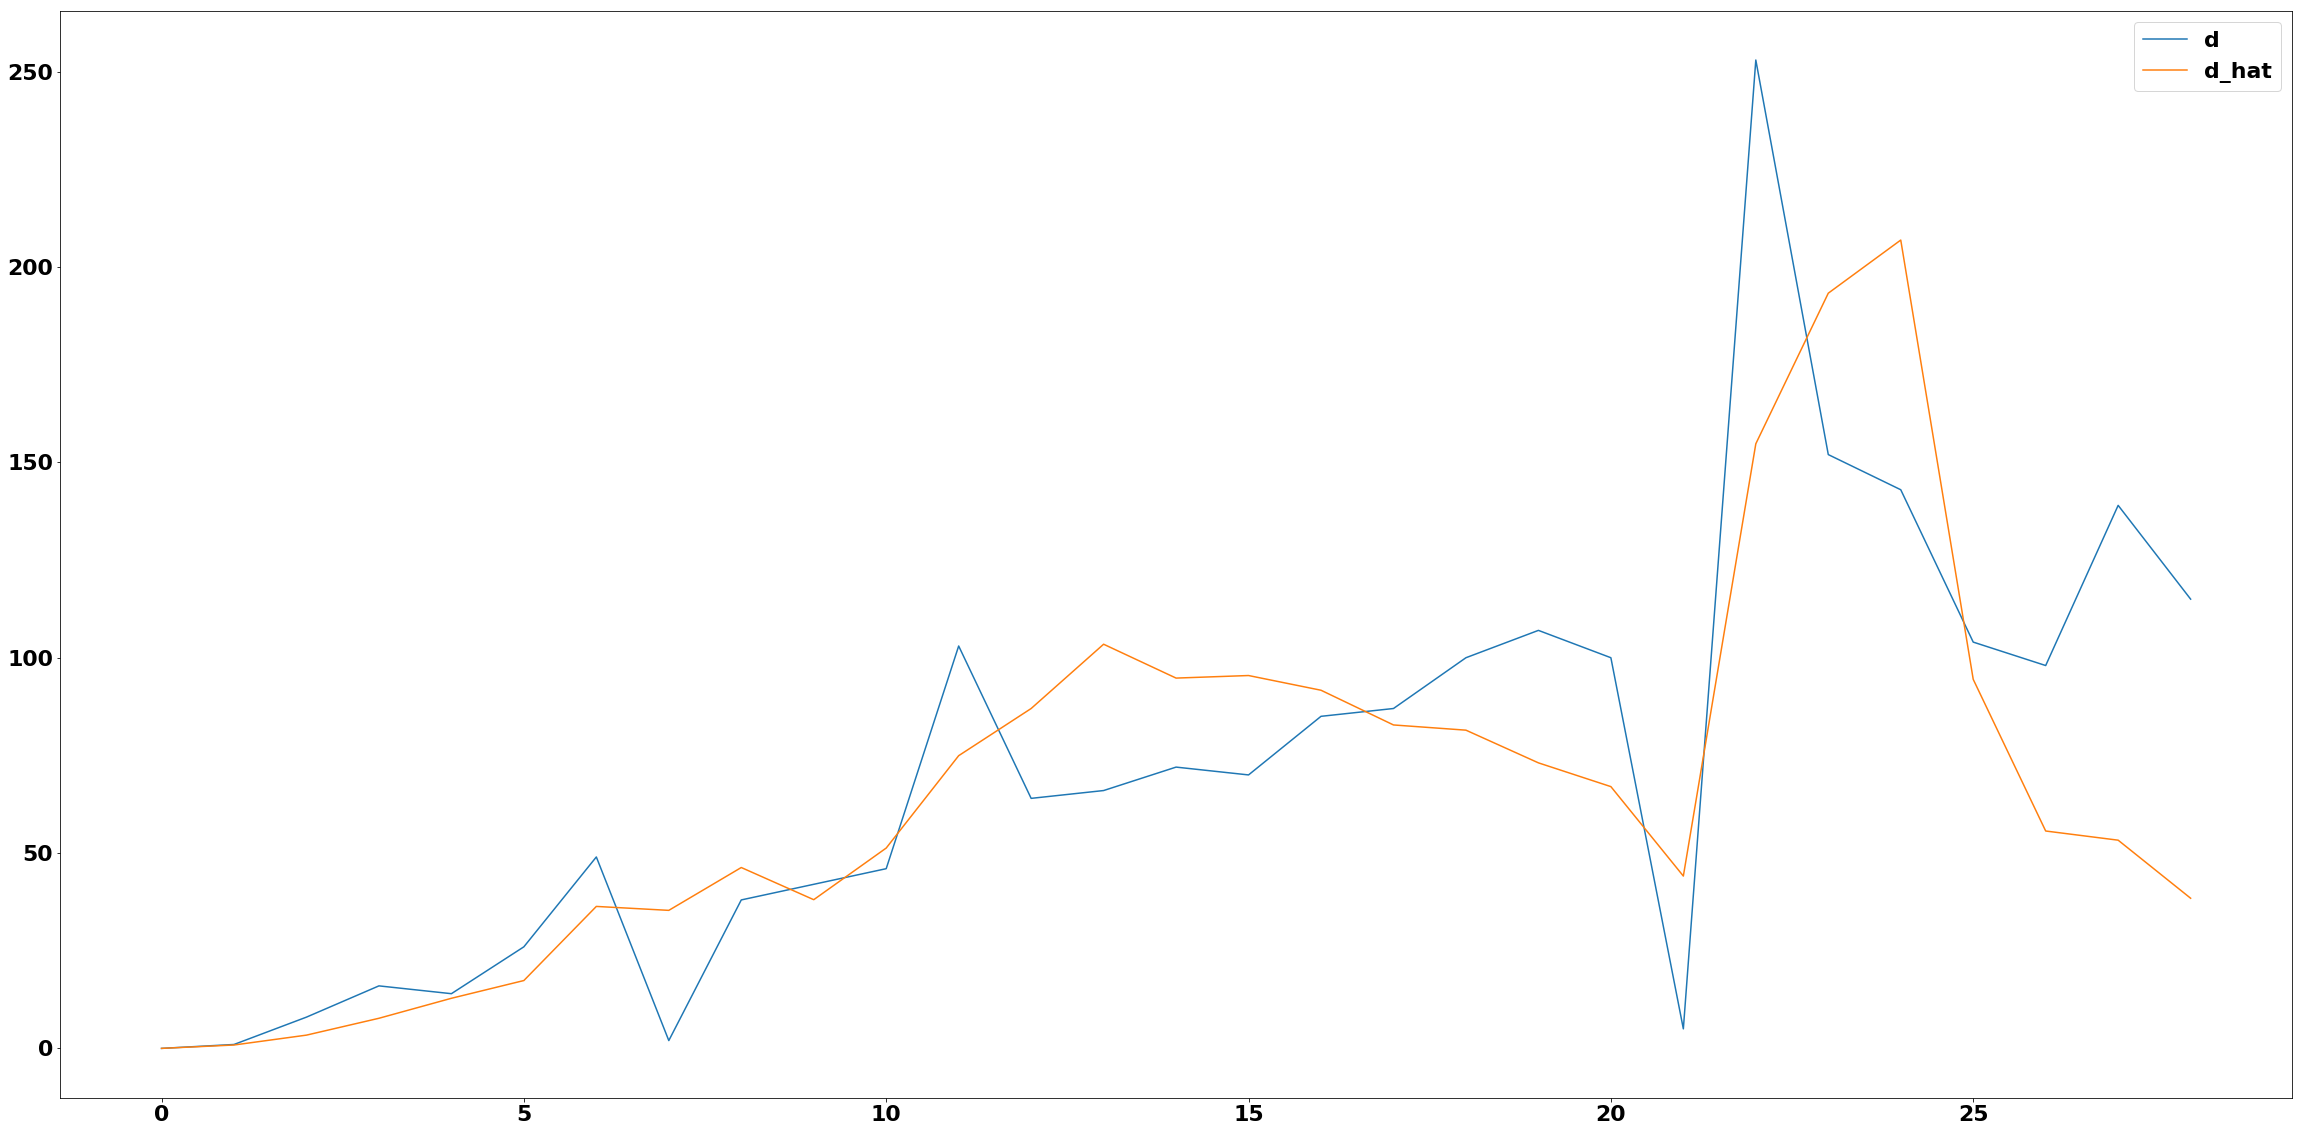

In [129]:
coronavirus_death_curve = estimate_death_curve(
    coronavirus_df['Infected'].values, 
    coronavirus_df['Dead'].values,
    K=3
)

coronavirus_death_curve.plot()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


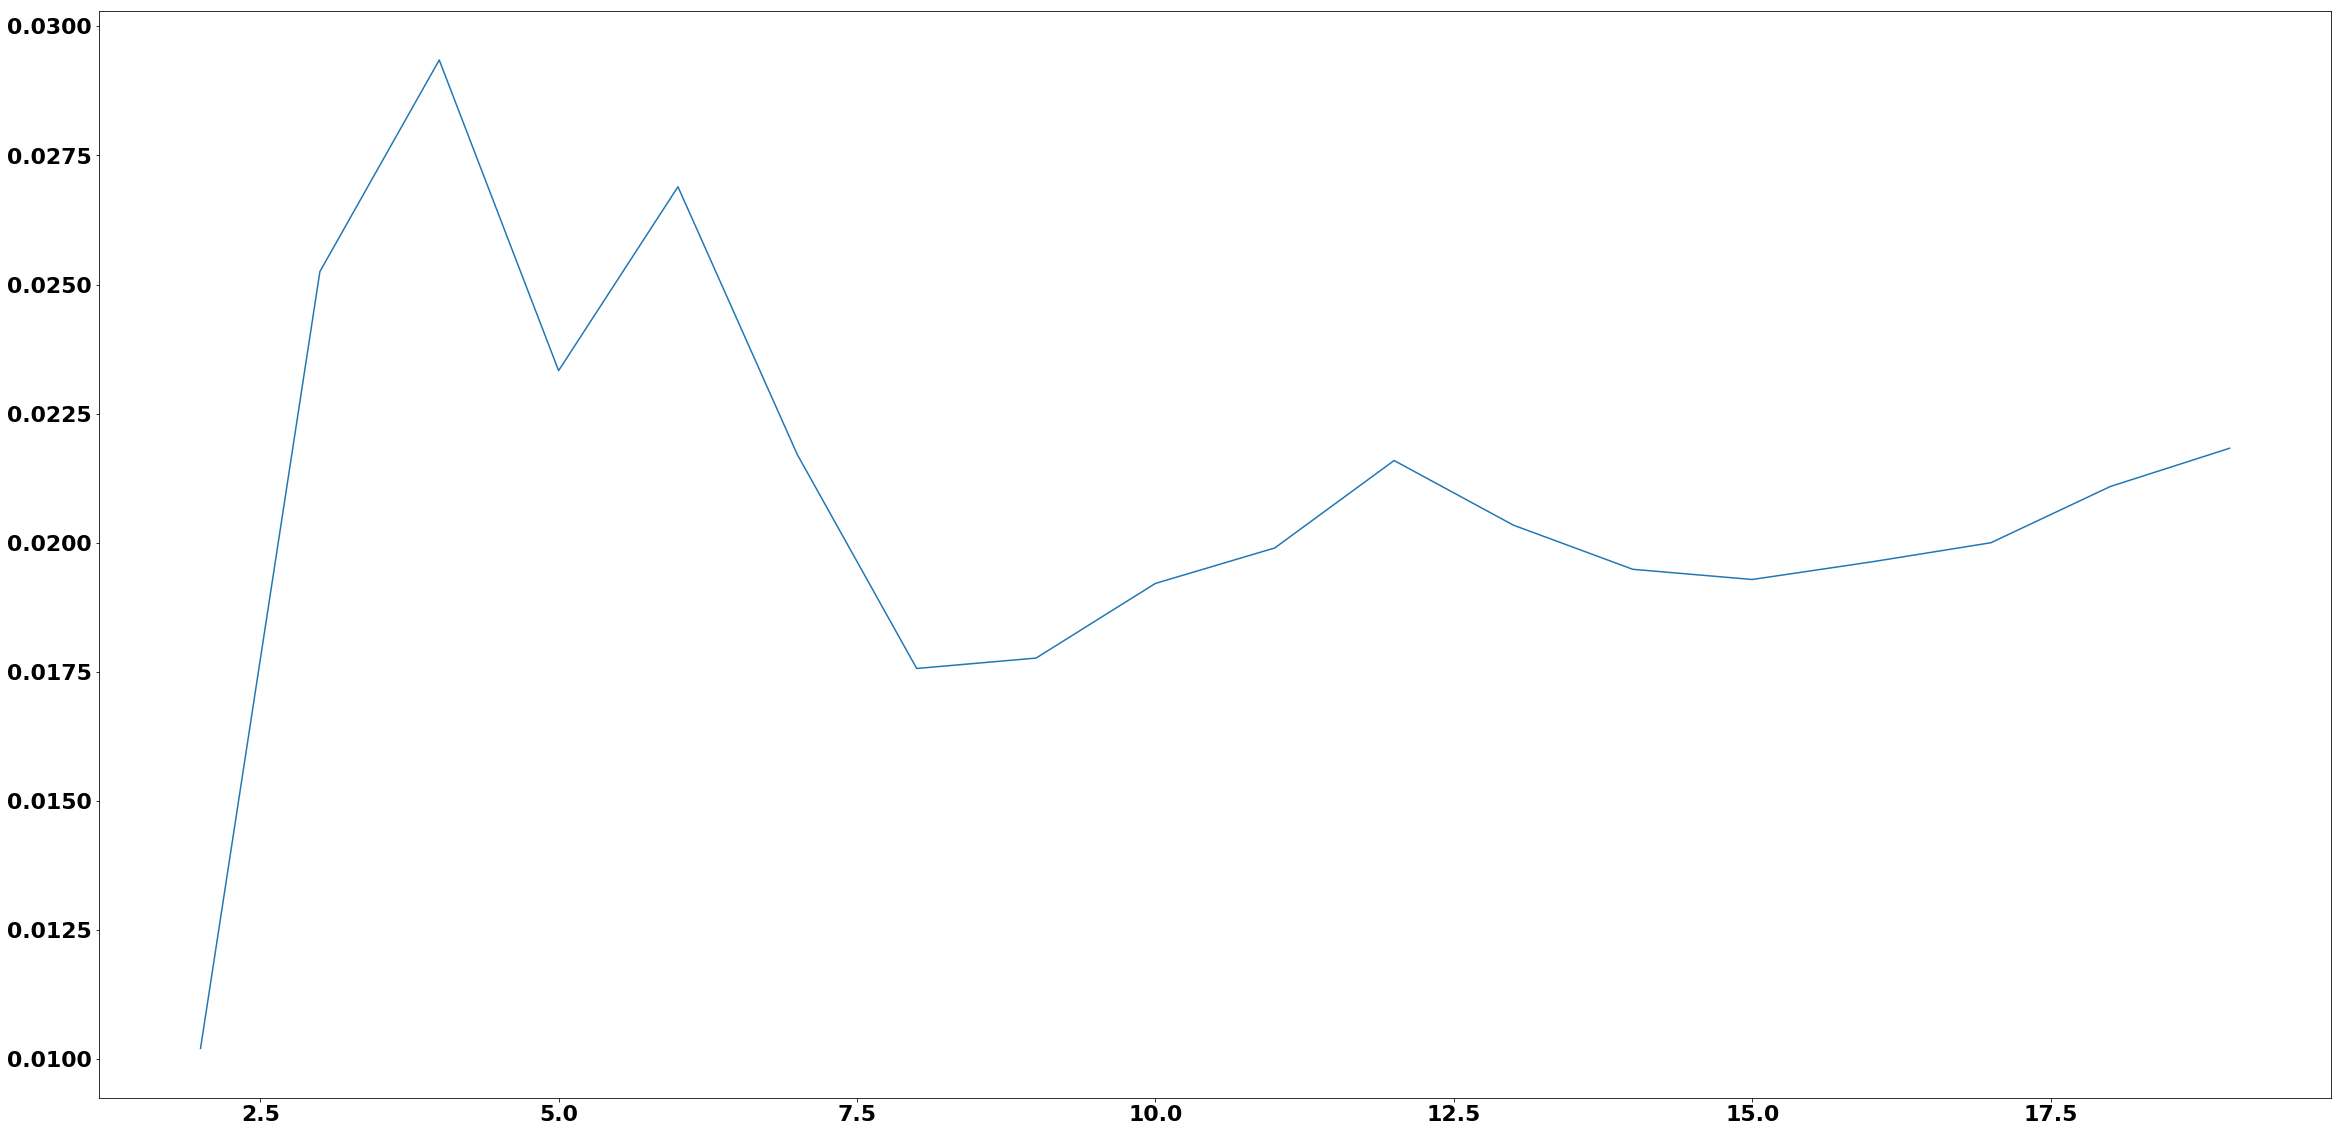

In [131]:
plot_censored_mortality_rate_estimation_evolution(coronavirus_df, 1, 20, K=2)

# Simulate Confidence Interval

## Probability Distribution of Mortality

In [136]:
corona_K = 3
corona_alpha = 0.008809720720720721

In [160]:
def simulate_infected_patients(n_patients, alpha, k0, alpha_k0, K, size=1):
    assert 0 <= k0 and k0 <= K
    
    # recovery probability after K period
    probabilities = [(1 - alpha_k0) * (1 - alpha) ** (K-1)]
    
    for k in range(k0):
        probabilities.append(alpha * (1 - alpha) ** k)
        
    probabilities.append(alpha_k0 * (1 - alpha) ** k0)
    
    for k in range(k0 + 1, K):
        probabilities.append(alpha * (1 - alpha_k0) * (1 - alpha) ** (k-1))
        
    print(probabilities)
        
    return np.random.multinomial(
        n_patients,
        probabilities,
        size=size
    )

def mean_squared_error(estimates, mean):
    return ((estimates - mean) ** 2).mean(1)

In [155]:
def estimate_hazard_rate(X, d, optimal_alpha=corona_alpha, optimal_K=corona_K, n_runs=100):
    T = X.shape[0]
    alpha_space = np.linspace(0.0001, 0.1, 1000)

    result = []
    
    for k0 in range(optimal_K):
        for alpha_k0 in alpha_space:
            alpha_death_curves = np.zeros((n_runs, T))
            
            for t, n_infected in enumerate(X):
                random_paths = simulate_infected_patients(n_infected, optimal_alpha, k0, alpha_k0, optimal_K)
                
                for j in range(n_runs):
                    alpha_death_curves[j, t:t+K] += random_paths[j][1:T - t + 1]
            
    
    for i, alpha in enumerate(alpha_space):
        print(f"({i}/{1000}) Simulating alpha={alpha}...")


        for t, n_infected in enumerate(X):
            random_paths = simulate_infected_patients(n_infected, alpha, K=K, size=n_runs)

            for j in range(n_runs):
                alpha_death_curves[j, t:t+K] += random_paths[j][1:T - t + 1]

        mean_death_curve = alpha_death_curves.mean(0)
    #         all_mean_squared_errors = mean_squared_error(alpha_death_curves, mean_death_curve)
        d_mse = mean_squared_error(d, mean_death_curve)
        print(f"\nConfidence Interval={lower_boundary, higher_boundary}\nTrue Mean Squared Error={true_mean_squared_error}\nIncluded?={true_mean_squared_error >= lower_boundary and true_mean_squared_error <= higher_boundary}\n")


In [152]:
estimate_hazard_rate(
    smooth_coronavirus_df['Infected'].values,
    smooth_coronavirus_df['Dead'].values
)

NameError: name 'estimate_hazard_rate' is not defined